In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve, average_precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy import stats as st
from tensorflow import keras


/home/kchen/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/kchen/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
data = pd.read_csv('data/train_dropold.csv')
data.head()

,Facility Location,Age,Sex,Race,Spanish Hispanic Origin,Primary Payor,Urban/Rural Classification,Distance From Facility,Charlson-Deyo Score,YEAR_OF_DIAGNOSIS,...,Median Income Quartile,stage,APR,facs_quart,t_stage,n_stage,m_stage,Keratinizing,Basaloid,Cloacogenic
0,0,-0.099296,1,3,1,0,2,-0.091786,0,2014,...,3,1,0,1.0,3,0,0,0,0,0
1,0,1.815465,0,3,1,1,2,-0.151867,0,2017,...,4,1,0,1.0,1,0,0,0,0,0
2,0,-1.491849,0,3,1,3,2,-0.106807,0,2014,...,3,1,0,1.0,1,0,0,0,0,0
3,2,0.422912,0,3,1,3,0,0.227104,0,2015,...,2,1,0,2.0,1,0,0,0,0,0
4,1,-0.360400,1,1,1,3,2,-0.216570,0,2016,...,1,2,0,1.0,2,0,0,0,0,0


In [4]:
test = pd.read_csv('data/test.csv')
test.head()

,Facility Location,Age,Sex,Race,Spanish Hispanic Origin,Primary Payor,Urban/Rural Classification,Distance From Facility,Charlson-Deyo Score,YEAR_OF_DIAGNOSIS,...,Median Income Quartile,stage,APR,facs_quart,t_stage,n_stage,m_stage,Keratinizing,Basaloid,Cloacogenic
0,0,1.380292,0,3,1,1,2,-0.223502,0,2019,...,3,1,0,1.0,1,0,0,0,0,0
1,1,0.858084,0,3,1,1,2,-0.047881,0,2019,...,3,3,0,2.0,2,1,0,0,0,0
2,3,0.248842,1,3,0,0,2,-0.043260,0,2019,...,3,1,0,2.0,1,0,0,0,0,0
3,0,0.509946,1,3,1,3,2,-0.151867,0,2019,...,4,2,0,1.0,2,0,0,0,0,0
4,0,0.161808,1,3,1,3,2,-0.213104,1,2019,...,3,1,0,1.0,1,0,0,0,1,0


In [5]:
data.drop('YEAR_OF_DIAGNOSIS', axis=1, inplace=True)
test.drop('YEAR_OF_DIAGNOSIS', axis=1, inplace=True)

In [6]:
print(data.shape, test.shape)

(6343, 23) (740, 23)


In [7]:
data['APR'].value_counts(normalize=True)

0    0.903989
1    0.096011
Name: APR, dtype: float64

In [8]:
test['APR'].value_counts(normalize=True)

0    0.909459
1    0.090541
Name: APR, dtype: float64

In [9]:
outcome = 'APR'
X = data.drop(outcome, axis=1)
y = data[outcome]
X_test = test.drop(outcome, axis=1)
y_test = test[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
rf = RandomForestClassifier(n_estimators=1250, max_features='auto', min_samples_leaf=8, min_samples_split=3, bootstrap=True, n_jobs=-1, random_state=0)
xgb = XGBClassifier(n_estimators=100, colsample_bytree=0.6, learning_rate=0.03, min_child_weight=6, subsample=0.6, n_jobs=-1, random_state=0)
lr = LogisticRegression(penalty='none', max_iter=9000, random_state=0)

In [11]:
input_shape = X.shape[1:]
def build_model(n_hidden=2, n_neurons=500, dropout=0.8, learning_rate=3e-2):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(dropout))
        model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(), metrics=['AUC'], optimizer=optimizer)
    return model
nn = build_model()

2022-07-27 17:02:49.870243: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 17:02:51.491379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18290 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:81:00.0, compute capability: 8.6
2022-07-27 17:02:51.492047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8936 MB memory:  -> device: 1, name: NVIDIA TITAN V, pci bus id: 0000:02:00.0, compute capability: 7.0


In [12]:
#calculate 95% confidence interval for auroc and auprc for each model
def auroc_ci(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    mean = roc_auc
    std = sqrt(roc_auc * (1.0 - roc_auc) / len(y_true))
    low  = mean - std
    high = mean + std
    return low, mean, high
#calculate auprc 95% ci for each model
def auprc_ci(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    mean = pr_auc
    std = sqrt(pr_auc * (1.0 - pr_auc) / len(y_true))
    low  = mean - std
    high = mean + std
    return low, mean, high

In [13]:
def fit_predict(model, X_train, y_train, X_test):
    model.fit(X, y)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return y_pred_proba


In [14]:
rf_y_pred = fit_predict(rf, X, y, X_test)
xgb_y_pred = fit_predict(xgb, X, y, X_test)
lr_y_pred = fit_predict(lr, X, y, X_test)

/home/kchen/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [15]:
history = nn.fit(X_train, y_train, batch_size=512, epochs=500, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)])

Epoch 1/500
 8/10 [=======================>......] - ETA: 0s - loss: 0.7449 - auc: 0.6057 

2022-07-27 17:03:20.499906: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 3s 49ms/step - loss: 0.7036 - auc: 0.6222 - val_loss: 1.1627 - val_auc: 0.5000
Epoch 2/500
10/10 [==============================] - 0s 11ms/step - loss: 0.4159 - auc: 0.6939 - val_loss: 0.3923 - val_auc: 0.7868
Epoch 3/500
10/10 [==============================] - 0s 11ms/step - loss: 0.3387 - auc: 0.6953 - val_loss: 0.5709 - val_auc: 0.8074
Epoch 4/500
10/10 [==============================] - 0s 11ms/step - loss: 0.3256 - auc: 0.6907 - val_loss: 0.4432 - val_auc: 0.7955
Epoch 5/500
10/10 [==============================] - 0s 11ms/step - loss: 0.3055 - auc: 0.7267 - val_loss: 0.4706 - val_auc: 0.7951
Epoch 6/500
10/10 [==============================] - 0s 11ms/step - loss: 0.2981 - auc: 0.7368 - val_loss: 0.3559 - val_auc: 0.7322
Epoch 7/500
10/10 [==============================] - 0s 11ms/step - loss: 0.3005 - auc: 0.7407 - val_loss: 0.3567 - val_auc: 0.7915
Epoch 8/500
10/10 [==============================] - 0s 11ms/step - loss: 0.2934 - auc: 

In [16]:
nn_y_pred = nn.predict(X_test)

In [17]:
rf_confidence = auroc_ci(y_test, rf_y_pred)
xgb_confidence = auroc_ci(y_test, xgb_y_pred)
lr_confidence = auroc_ci(y_test, lr_y_pred)
nn_confidence = auroc_ci(y_test, nn_y_pred)

In [18]:
print('Random Forest AUROC:', rf_confidence, 'AUROC CI:', rf_confidence)
print('XGBoost AUROC:', xgb_confidence, 'AUROC CI:', xgb_confidence)
print('Logistic Regression AUROC:', lr_confidence, 'AUROC CI:', lr_confidence)
print('Neural Network AUROC:', nn_confidence, 'AUROC CI:', nn_confidence)

Random Forest AUROC: (0.7807211252192786, 0.795546783171808, 0.8103724411243375) AUROC CI: (0.7807211252192786, 0.795546783171808, 0.8103724411243375)
XGBoost AUROC: (0.790383947337233, 0.8049499900201814, 0.8195160327031298) AUROC CI: (0.790383947337233, 0.8049499900201814, 0.8195160327031298)
Logistic Regression AUROC: (0.7308836506515545, 0.7468674458317625, 0.7628512410119704) AUROC CI: (0.7308836506515545, 0.7468674458317625, 0.7628512410119704)
Neural Network AUROC: (0.7538246161652095, 0.7693109489698609, 0.7847972817745122) AUROC CI: (0.7538246161652095, 0.7693109489698609, 0.7847972817745122)


In [19]:
#create labels for roc curves
rf_label = 'RF: ' + str(round(rf_confidence[1], 3)) + ' (' + str(round(rf_confidence[0], 3)) + ' - ' + str(round(rf_confidence[2], 3)) + ')'
xgb_label = 'XGB: ' + str(round(xgb_confidence[1], 3)) + ' (' + str(round(xgb_confidence[0], 3)) + ' - ' + str(round(xgb_confidence[2], 3)) + ')'
nn_label = 'NN: ' + str(round(nn_confidence[1], 3)) + ' (' + str(round(nn_confidence[0], 3)) + ' - ' + str(round(nn_confidence[2], 3)) + ')'
lr_label = 'LR: ' + str(round(lr_confidence[1], 3)) + ' (' + str(round(lr_confidence[0], 3)) + ' - ' + str(round(lr_confidence[2], 3)) + ')'

In [20]:
#calculate tpr and fpr for each model
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_y_pred)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_pred)

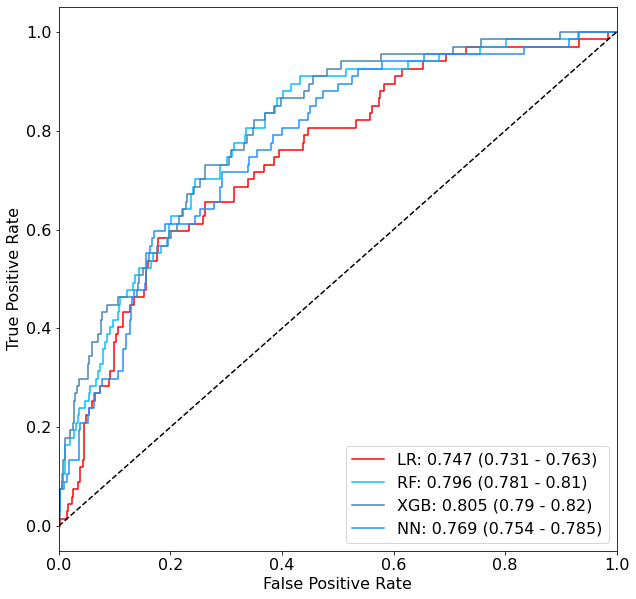

In [21]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
#plot the ROC curves for each model
plt.figure(figsize=(10,10))
plt.plot(lr_fpr, lr_tpr, color='red', label=lr_label)
plt.plot(rf_fpr, rf_tpr, color='deepskyblue', label=rf_label)
plt.plot(xgb_fpr, xgb_tpr, color='steelblue', label=xgb_label)
plt.plot(nn_fpr, nn_tpr, color='dodgerblue', label=nn_label)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.savefig('results/roc.png')

In [22]:
rf_auprc_ci = auprc_ci(y_test, rf_y_pred)
xgb_auprc_ci = auprc_ci(y_test, xgb_y_pred)
lr_auprc_ci = auprc_ci(y_test, lr_y_pred)
nn_auprc_ci = auprc_ci(y_test, nn_y_pred)

In [23]:
#calculate precision and recall for each model
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_y_pred)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_y_pred)
nn_precision, nn_recall, _ = precision_recall_curve(y_test, nn_y_pred)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_y_pred)

In [24]:
#create labels for precision recall curves
rf_prc_label = 'RF: ' + str(round(rf_auprc_ci[1], 3)) + ' (' + str(round(rf_auprc_ci[0], 3)) + ' - ' + str(round(rf_auprc_ci[2], 3)) + ')'
xgb_prc_label = 'XGB: ' + str(round(xgb_auprc_ci[1], 3)) + ' (' + str(round(xgb_auprc_ci[0], 3)) + ' - ' + str(round(xgb_auprc_ci[2], 3)) + ')'
nn_prc_label = 'NN: ' + str(round(nn_auprc_ci[1], 3)) + ' (' + str(round(nn_auprc_ci[0], 3)) + ' - ' + str(round(nn_auprc_ci[2], 3)) + ')'
lr_prc_label = 'LR: ' + str(round(lr_auprc_ci[1], 3)) + ' (' + str(round(lr_auprc_ci[0], 3)) + ' - ' + str(round(lr_auprc_ci[2], 3)) + ')'

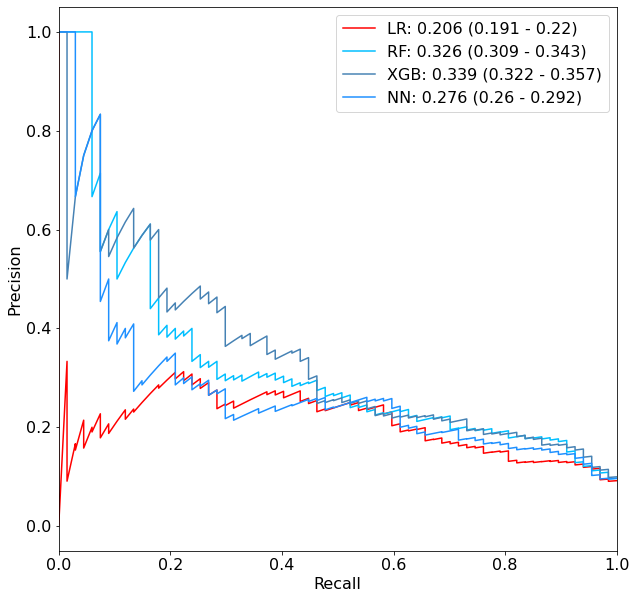

In [25]:
#plot the precision recall curves for each model
matplotlib.rcParams.update({'font.size': 16})
#plot the ROC curves for each model
plt.figure(figsize=(10,10))
plt.plot(lr_recall, lr_precision, color='red', label=lr_prc_label)
plt.plot(rf_recall, rf_precision, color='deepskyblue', label=rf_prc_label)
plt.plot(xgb_recall, xgb_precision, color='steelblue', label=xgb_prc_label)
plt.plot(nn_recall, nn_precision, color='dodgerblue', label=nn_prc_label)
plt.legend(loc="upper right")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.savefig('results/prc.png')

In [30]:
fi = xgb.feature_importances_
fi_df = pd.DataFrame(fi, columns=['importance'])
fi_df['feature'] = X.columns
fi_df.sort_values(by='importance', ascending=False, inplace=True)
fi_df.head()



/home/kchen/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,importance,feature
16,0.208294,t_stage
10,0.129930,Tumor Size
14,0.071440,stage
11,0.059328,Lymphovascular Invasion
17,0.047506,n_stage


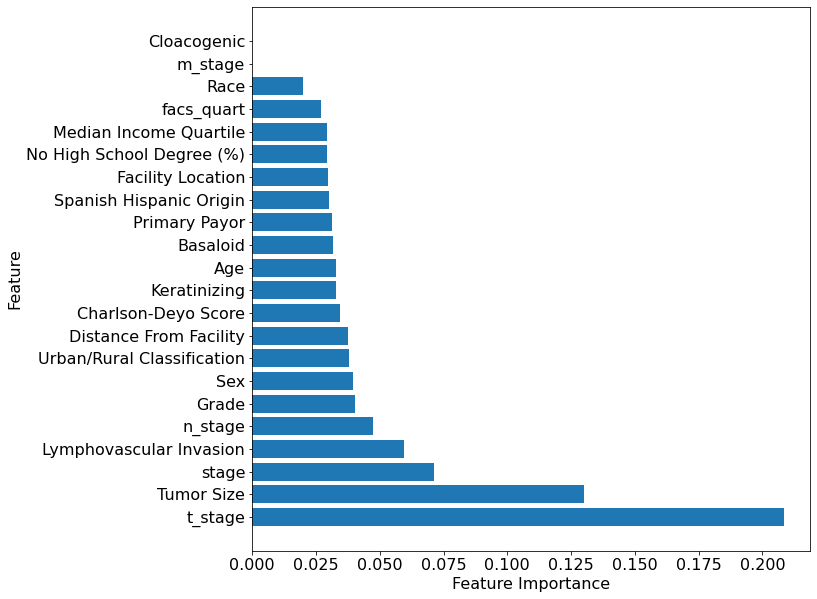

In [33]:
#plot the feature importance in a horizontal bar chart with the most important features at the top, colored by importance
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,10))
plt.barh(range(len(fi)), fi_df['importance'], align='center')
plt.yticks(range(len(fi)), fi_df['feature'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.savefig('results/fi_xgb.png', bbox_inches='tight')


In [34]:
import shap
import seaborn as sns
from matplotlib import pyplot as plt

In [38]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X.sample(n=100))


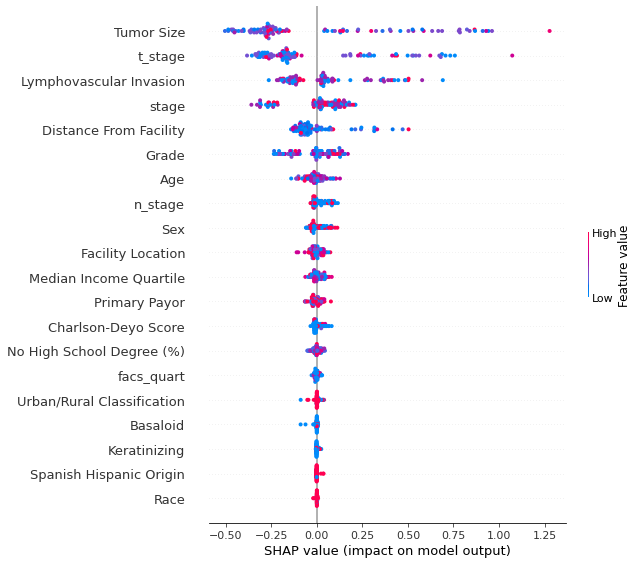

In [36]:
shap.summary_plot(shap_values, X.sample(n=100))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


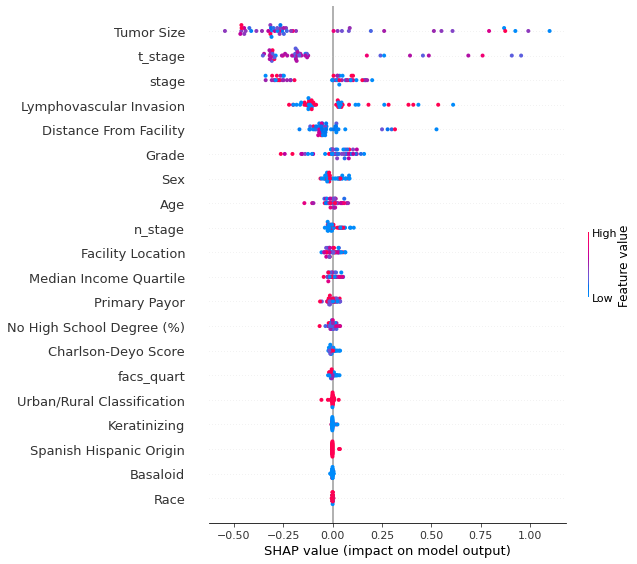

In [62]:
shap_values = explainer.shap_values(X.sample(n=50))
shap.summary_plot(shap_values = shap_values,
                  features = X.sample(n=50),
                  feature_names = X.columns,
                  plot_size = 'auto',
                  #cmap=plt.get_cmap("flare"),
                  sort=True, show=False)
plt.savefig('results/shap_xgb.png', bbox_inches='tight')

In [55]:
shap_values = explainer.shap_values(X.sample(n=50))

ValueError: Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.

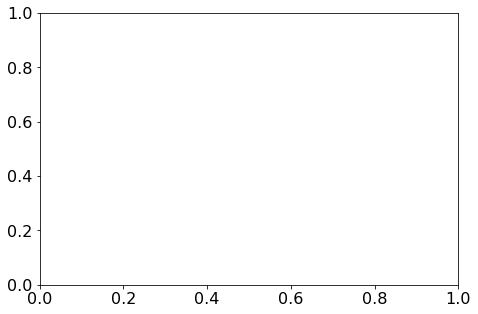

In [60]:
shap.dependence_plot(ind='Tumor Size',
                     shap_values=shap_values,
                     features=X.sample(n=50),
                    feature_names=X.columns,
                    show=True)

In [33]:
explainer = shap.Explainer(xgb, X.sample(n=1000))
shap_values = explainer(X.sample(n=1000))

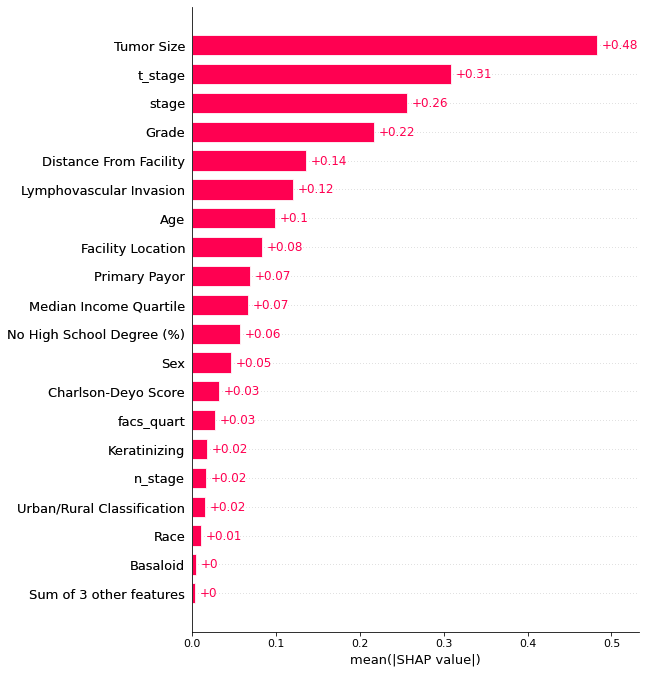

In [34]:
shap.plots.bar(shap_values, max_display=20)

In [76]:
vals = np.abs(shap_values[0]).mean(0)
feature_names = X.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head(10)

TypeError: 'numpy.float32' object is not iterable

In [63]:
data['Lymph Vascular Invasion'].value_counts()

0    24206
2     9232
1     4908
Name: Lymph Vascular Invasion, dtype: int64

In [64]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test.sample(n=50))
shap_obj = explainer(X_test.sample(n=50))


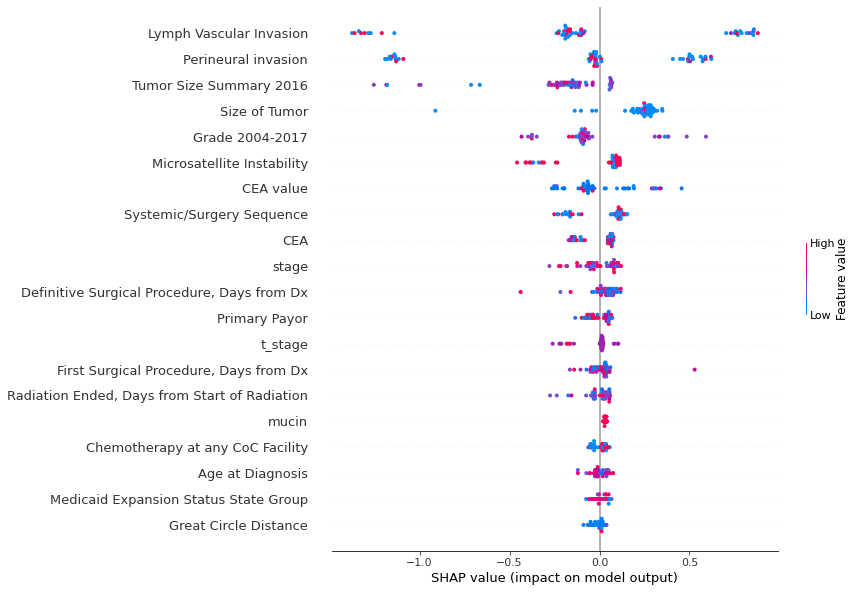

In [65]:
shap.summary_plot(shap_values = shap_values,
                  features = X_test.sample(n=50),
                  feature_names = X_test.columns,
                  plot_size = (10,10),
                  #cmap=plt.get_cmap("flare"),
                  sort=True, show=True)



In [67]:
data.head()

,Lymph Vascular Invasion,Perineural invasion,Grade 2004-2017,Size of Tumor,Microsatellite Instability,CEA value,CEA,Systemic/Surgery Sequence,"Definitive Surgical Procedure, Days from Dx",stage,...,"First Surgical Procedure, Days from Dx",Chemotherapy at any CoC Facility,"Radiation Ended, Days from Start of Radiation",Tumor Size Summary 2016,Age at Diagnosis,Great Circle Distance,Primary Payor,t_stage,Medicaid Expansion Status State Group,pcr
0,2,2,2,0.241589,2,-0.248604,0,0,-0.464773,4,...,-0.389753,1,-0.157566,-0.047336,1.506494,-0.229448,1,3,0,0
1,0,0,2,0.241589,0,-0.488007,1,0,-0.537918,4,...,-0.461946,1,-0.157566,-0.047336,0.850634,-0.039498,3,3,2,0
2,0,0,2,-0.919899,1,-0.248604,2,1,-0.775640,9,...,-0.696572,1,-0.078491,-0.047336,-0.707034,-0.185459,3,3,0,1
3,0,0,0,-0.023894,2,-0.348355,1,0,0.083816,4,...,0.151694,1,-0.236641,-0.047336,1.998389,-0.277435,1,3,2,0
4,0,0,2,-0.090265,2,-0.248604,2,0,0.358111,4,...,0.422417,1,0.000583,-0.047336,1.178564,-0.185459,1,3,0,0


In [35]:
explainer = shap.DeepExplainer(nn, data=X_train.sample(100))
shap_values = explainer.shap_values(X.sample(n=100))
shap_obj = explainer(X.sample(n=100))

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


AttributeError: Exception encountered when calling layer "sequential" (type Sequential).

'tuple' object has no attribute 'rank'

Call arguments received:
  • inputs=['       Lymph Vascular Invasion  Perineural invasion  Grade 2004-2017  \\\n8055                         2                    2                2   \n5839                         2                    0                2   \n8655                         0                    0                1   \n9976                         0                    0                2   \n33161                        2                    0                2   \n...                        ...                  ...              ...   \n32972                        0                    2                0   \n34309                        1                    1                2   \n482                          0                    0                2   \n4421                         0                    0                2   \n7333                         0                    0                2   \n\n       Size of Tumor  Microsatellite Instability  CEA value  CEA  \\\n8055        0.241589                           2  -0.248604    0   \n5839       -0.090265                           1  -0.378281    1   \n8655       -0.422118                           2  -0.248604    2   \n9976       -0.090265                           2  -0.248604    0   \n33161       0.573443                           2  -0.428156    1   \n...              ...                         ...        ...  ...   \n32972      -0.090265                           2  -0.308455    1   \n34309      -1.251752                           2  -0.318430    1   \n482        -0.090265                           2  -0.527907    1   \n4421        1.502633                           2  -0.248604    2   \n7333       -0.554860                           2  -0.268555    1   \n\n       Systemic/Surgery Sequence  Definitive Surgical Procedure, Days from Dx  \\\n8055                           0                                     0.924986   \n5839                           0                                    -0.355055   \n8655                           1                                    -0.483059   \n9976                           0                                     0.028957   \n33161                          1                                    -0.483059   \n...                          ...                                          ...   \n32972                          0                                     0.687264   \n34309                          1                                     4.490816   \n482                            1                                    -0.592777   \n4421                           1                                    -0.848785   \n7333                           0                                    -0.044188   \n\n       stage  mucin  First Surgical Procedure, Days from Dx  \\\n8055       1      1                                0.981912   \n5839       9      1                               -0.281463   \n8655       9      1                               -0.407801   \n9976       9      1                                0.097549   \n33161      9      1                               -0.407801   \n...      ...    ...                                     ...   \n32972      8      1                                0.747285   \n34309      4      1                                1.433117   \n482        8      1                               -0.516090   \n4421       6      1                               -0.768765   \n7333       4      1                                0.025356   \n\n       Chemotherapy at any CoC Facility  \\\n8055                                  0   \n5839                                  1   \n8655                                  0   \n9976                                  1   \n33161                                 0   \n...                                 ...   \n32972                                 0   \n34309                                 0   \n482                                   0   \n4421                                  0   \n7333                                  1   \n\n       Radiation Ended, Days from Start of Radiation  Tumor Size Summary 2016  \\\n8055                                       -1.976287                -0.047336   \n5839                                       -0.078491                -0.629671   \n8655                                       -0.078491                -0.047336   \n9976                                       -0.157566                -0.047336   \n33161                                      -0.078491                -0.047336   \n...                                              ...                      ...   \n32972                                       0.475032                -0.047336   \n34309                                       0.237808                -0.047336   \n482                                        -0.078491                -0.120128   \n4421                                        0.000583                -0.047336   \n7333                                       -0.157566                -0.047336   \n\n       Age at Diagnosis  Great Circle Distance  Primary Payor  t_stage  \\\n8055           0.932616              -0.185459              1        3   \n5839          -0.870999              -0.151468              2        3   \n8655           0.358739              -0.262439              1        3   \n9976          -0.051174              -0.189458              3        3   \n33161          0.276756              -0.185459              3        3   \n...                 ...                    ...            ...      ...   \n32972         -0.707034              -0.134473              3        2   \n34309         -0.051174              -0.146470              0        3   \n482           -1.280911               0.273419              3        2   \n4421           0.276756              -0.187459              3        4   \n7333           0.850634              -0.194457              1        3   \n\n       Medicaid Expansion Status State Group  \n8055                                       2  \n5839                                       1  \n8655                                       2  \n9976                                       0  \n33161                                      0  \n...                                      ...  \n32972                                      1  \n34309                                      0  \n482                                        0  \n4421                                       2  \n7333                                       0  \n\n[100 rows x 20 columns]']
  • training=None
  • mask=None

In [ ]:
import sklearn
print("shap: {}, sklearn: {} numpy: {}".format(shap.__version__, sklearn.__version__, np.__version__))

shap: 0.40.0, sklearn: 1.0.2 numpy: 1.21.0


In [ ]:
explainer = shap.TreeExplainer(rf, X.sample(n=4000))
shap_values = explainer.shap_values(X_test.sample(n=4000).values)
shap.summary_plot(shap_values, X_test.sample(n=4000))
#create a dataframe of the shap values sorted from highest to lowest
shap_values[0].shape
vals = np.abs(shap_values[0]).mean(0)
feature_names = X.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head(10)
#export the dataframe to excel (easier to change the column names)
feature_importance.to_excel('results/shap.xlsx')


  1%|                   | 87/8000 [01:38<148:33]       

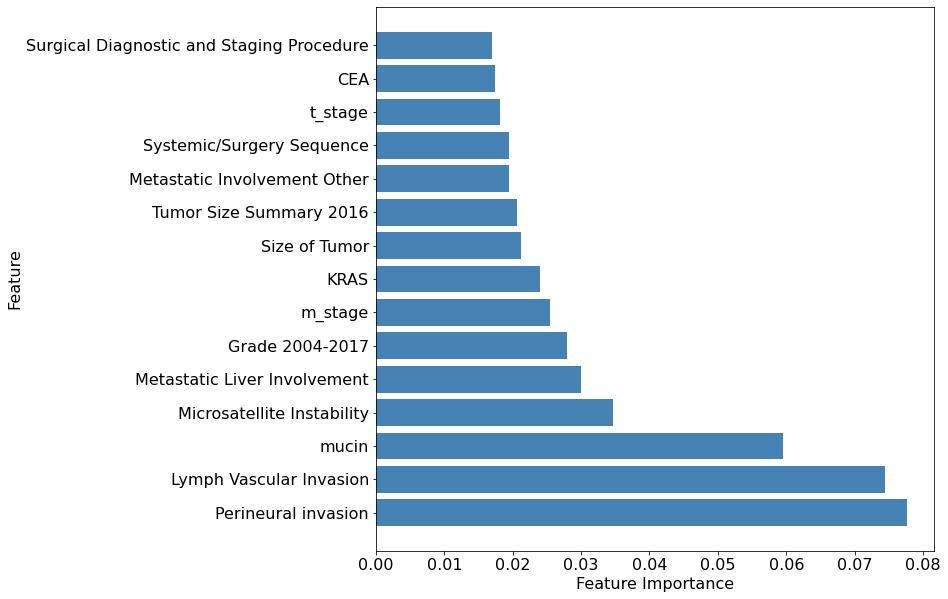

In [ ]:
#plot the top 15 feature on a horizontal bar chart, with highest on the top
plt.figure(figsize=(10,10))
plt.barh(np.arange(15), fi[fi_sorted], color='steelblue')
plt.yticks(np.arange(15), X.columns[fi_sorted])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.savefig('../results/xgb_fi2.png', bbox_inches='tight')
